# Exploratory Data Analysis

In this notebook you will explore the citation dataset. You will already have installed py2neo, pandas, and matplotlib when setting up our environment, so you will now import them (remember to unset Reset all runtimes before running):

In [ ]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Update the cell below to use the IP Address, Bolt Port, and Password, as you did previously.

In [ ]:
# Change the line of code below to use the Bolt URL,  and Password of your Neo4j Database instance.
# graph = Graph("<Bolt URL>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://localhost:7687", auth=("neo4j", "letmein"))

## What's in our database?

Run the following query to check how many nodes the database contains:

In [ ]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [Node('Venue', constraints=["Constraint( id=6, name='constraint_ae6d9b7b', type='UNIQUENESS', schema=(:Venue {name}), ownedIndex=5 )"], indexes=[], name='Venue'),
   Node('Article', constraints=["Constraint( id=2, name='constraint_2e688049', type='UNIQUENESS', schema=(:Article {index}), ownedIndex=1 )"], indexes=[], name='Article'),
   Node('Author', constraints=["Constraint( id=4, name='constraint_293d3e9e', type='UNIQUENESS', schema=(:Author {name}), ownedIndex=3 )"], indexes=[], name='Author')],
  'relationships': [VENUE(Node('Article', constraints=["Constraint( id=2, name='constraint_2e688049', type='UNIQUENESS', schema=(:Article {index}), ownedIndex=1 )"], indexes=[], name='Article'), Node('Venue', constraints=["Constraint( id=6, name='constraint_ae6d9b7b', type='UNIQUENESS', schema=(:Venue {name}), ownedIndex=5 )"], indexes=[], name='Venue')),
   AUTHOR(Node('Article', constraints=["Constraint( id=2, name='constraint_2e688049', type='UNIQUENESS', schema=(:Article {inde

If you run that query (CALL db.schema.visualization()) in  Neo4j Browser, you see the following visualization:

<img src="https://github.com/neo4j-contrib/training-v3/blob/master/modules/gds-data-science/supplemental/notebooks/images/data-science-training.png?raw=1" alt="Graph Data Model"/>


Drill down a bit. How many nodes do we have for each of these labels? Run this code:

In [ ]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) AS count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


You can visualize the counts using matplotlib> Run the following code:

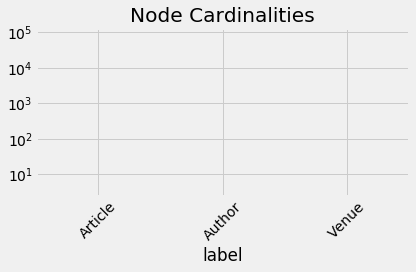

In [ ]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What types of relationships do we have in our graph? Run this code:

In [ ]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) AS count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


You can visualize the counts using matplotlib. Run  the following code:

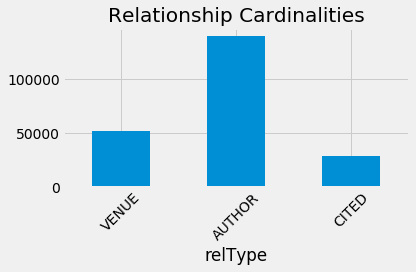

In [ ]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Next,  you will explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.
Run this code:

In [ ]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY rand()
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,article,author,venue,citationsGiven,citationsReceived
0,Design and implementation of multipurpose sing...,R.S. Sandesh,advances in computing and communications,0,0
1,Design and implementation of multipurpose sing...,Nithya Venkatesan,advances in computing and communications,0,0
2,Longer keys may facilitate side channel attacks,Colin D. Walter,Lecture Notes in Computer Science,0,0
3,Pruning graphs with digital search trees. Appl...,Eric Thierry,Lecture Notes in Computer Science,0,0
4,Pruning graphs with digital search trees. Appl...,Olivier Raynaud,Lecture Notes in Computer Science,0,0
5,Pruning graphs with digital search trees. Appl...,Jean-Marc Lanlignel,Lecture Notes in Computer Science,0,0
6,Using Task Knowledge to Guide Interactor Speci...,José Creissac Campos,Lecture Notes in Computer Science,1,0
7,Comment on Bell's quadratic quotient method fo...,Leslie Lamport,Communications of The ACM,1,2
8,Implementing chord for HP2P network,Yang Cao,Lecture Notes in Computer Science,1,0
9,Implementing chord for HP2P network,Ertao Lv,Lecture Notes in Computer Science,1,0


Examine the citation data more closely. Here is a query that returns the number of citations that each article has, and then creates a distribution of those counts using pandas `describe` function. Run this code:

In [ ]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


Most articles are being cited very few times. 99% of articles have 8 citations or less. Notice that one article has been cited more than 200 times. You will use a log scale histogram to visualize the data. Run this code:

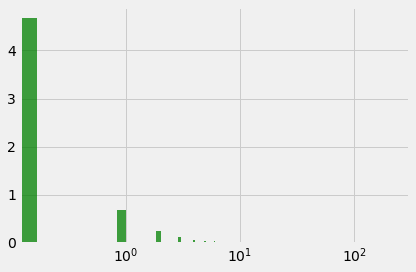

In [ ]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise instructions

1. Create a similar query showing the articles that cite the most other papers? Note that you will only need to do a slight tweak of the Cypher query to do this. 
2. What about a distribution of the number of articles published by authors?

Keep the results of this exercise handy as they may be useful for the quiz at the end of this module.